Using mobilenet v2 for making a classifier for alpaca or not

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Prepare dataset first from the directory

In [2]:
directory='dataset/'
IMAGE_SIZE=(160,160)
BATCH_SIZE=32
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(directory=directory,shuffle=True,image_size=IMAGE_SIZE,seed=42,validation_split=0.2,subset='training',batch_size=BATCH_SIZE)
validation_dataset=tf.keras.preprocessing.image_dataset_from_directory(directory=directory,shuffle=True,image_size=IMAGE_SIZE,seed=42,validation_split=0.2,subset='validation',batch_size=BATCH_SIZE)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


define data augmentator and preprocessing

In [3]:
AUTOTUNE=tf.data.AUTOTUNE
train_dataset=train_dataset.prefetch(AUTOTUNE)

In [4]:
def data_augmentator():
    data_augment=tf.keras.Sequential()
    data_augment.add(tf.keras.layers.RandomFlip('horizontal'))
    data_augment.add(tf.keras.layers.RandomRotation(factor=0.2))
    return data_augment

In [5]:
data_augmentation=data_augmentator()
preprocess_input=tf.keras.applications.mobilenet_v2.preprocess_input

In [287]:
base_model=tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE+(3,),include_top=False,weights='imagenet')


In [288]:
base_model.trainable=False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_61 (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_61[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [303]:
for layer in base_model.layers:
    # print(layer.name)
    if 'relu' in layer.name:
        layer=tf.keras.layers.ELU
        print(layer)
        
    


<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activation.elu.ELU'>
<class 'keras.src.layers.activatio

In [295]:
for layer in base_model.layers:
    print(layer)

In [261]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_38[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [296]:
def alpaca_model(image_shape,data_augmentation=data_augmentator()):
    input_shape=image_shape+(3,)
    
    inputs=tf.keras.Input(shape=input_shape)
    #Preprocessing
    X=data_augmentation(inputs)
    X=preprocess_input(X)
    print(X.shape)
    
    X=base_model(X,training=False)
    X=tf.keras.layers.GlobalAveragePooling2D()(X)
    print(X.shape)
    X=tf.keras.layers.Dropout(rate=0.2)(X)
    pred_layer=tf.keras.layers.Dense(1)
    X_out=pred_layer(X)
    print(X_out.shape)

    model=tf.keras.Model(inputs=inputs,outputs=X_out)
    return model

In [297]:
initial_epoch=5
model1=alpaca_model(IMAGE_SIZE)
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])
model1.summary()

(None, 160, 160, 3)
(None, 1280)
(None, 1)
Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_29 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_39 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_39 (TFOpL  (None, 160, 160, 3)       0         
 ambda)                                                          
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
               

In [298]:
history=model1.fit(train_dataset,epochs=initial_epoch,validation_data=validation_dataset)

Epoch 1/5


9/9 [==============================] - 7s 427ms/step - loss: 0.9059 - accuracy: 0.5000 - val_loss: 0.5285 - val_accuracy: 0.7231
Epoch 2/5
9/9 [==============================] - 3s 307ms/step - loss: 0.6692 - accuracy: 0.5763 - val_loss: 0.4819 - val_accuracy: 0.6769
Epoch 3/5
9/9 [==============================] - 3s 309ms/step - loss: 0.5840 - accuracy: 0.6527 - val_loss: 0.4356 - val_accuracy: 0.6923
Epoch 4/5
9/9 [==============================] - 3s 284ms/step - loss: 0.5103 - accuracy: 0.7023 - val_loss: 0.3284 - val_accuracy: 0.8615
Epoch 5/5
9/9 [==============================] - 3s 285ms/step - loss: 0.4719 - accuracy: 0.7672 - val_loss: 0.3121 - val_accuracy: 0.8308


(0.5, 1.0)

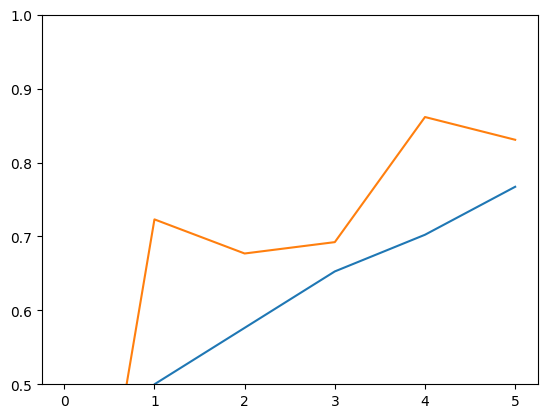

In [300]:
acc=[0.]+history.history['accuracy']
val_acc=[0.]+history.history['val_accuracy']
plt.plot(acc)
plt.plot(val_acc)
plt.ylim([0.5,1.0])

(0.5, 1.0)

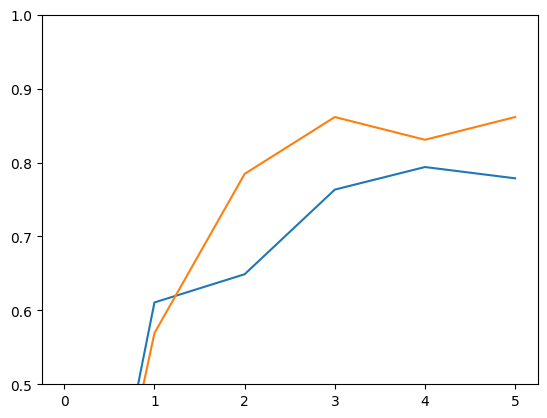

In [286]:
acc_1=[0.]+history.history['accuracy']
val_acc_1=[0.]+history.history['val_accuracy']
plt.plot(acc_1)
plt.plot(val_acc_1)
plt.ylim([0.5,1.0])

In [149]:
base_model.trainable=True
fine_tune_at=126
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable=False
    if 'relu' in layer.name:
        print(layer)
    


In [115]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_16[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [131]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [132]:
epochs=5
total_epoch=initial_epoch+epochs
history_new=model1.fit(train_dataset,validation_data=validation_dataset,epochs=total_epoch,initial_epoch=history.epoch[-1])

Epoch 5/10


9/9 [==============================] - 9s 460ms/step - loss: 0.4970 - accuracy: 0.7977 - val_loss: 0.1499 - val_accuracy: 0.9692
Epoch 6/10
9/9 [==============================] - 4s 366ms/step - loss: 0.3294 - accuracy: 0.8626 - val_loss: 0.1414 - val_accuracy: 0.9077
Epoch 7/10
9/9 [==============================] - 4s 365ms/step - loss: 0.2401 - accuracy: 0.9198 - val_loss: 0.1710 - val_accuracy: 0.8615
Epoch 8/10
9/9 [==============================] - 3s 342ms/step - loss: 0.1863 - accuracy: 0.8855 - val_loss: 0.1036 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 4s 361ms/step - loss: 0.1495 - accuracy: 0.9504 - val_loss: 0.1192 - val_accuracy: 0.9077
Epoch 10/10
9/9 [==============================] - 3s 344ms/step - loss: 0.1055 - accuracy: 0.9542 - val_loss: 0.0721 - val_accuracy: 0.9692
